Epoch 1/500


C:\Users\root3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2984 - val_loss: 0.3063
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2826 - val_loss: 0.2908
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2674 - val_loss: 0.2758
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2528 - val_loss: 0.2613
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2387 - val_loss: 0.2473
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.2251 - val_loss: 0.2338
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.2121 - val_loss: 0.2208
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1996 - val_loss: 0.2083
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1876 - val_loss: 0.1963
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1760 - val_loss: 0.1847
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1650 - val_loss: 0.1736
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1545 - val_loss: 0.1631
Ep

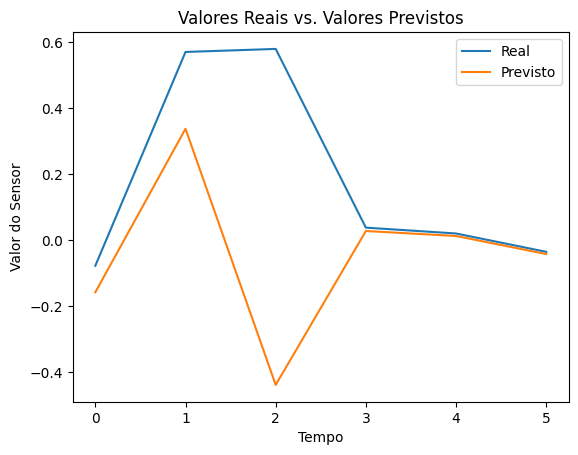

In [34]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

#ficheiro csv
file_path = r'..\Datasets\Acceleration\Till reached distance\10m\aggressive\BMW e36\acceleration 0m 10m aggressive-23-04-2023-19-42-30.json'

# Load dos dados do ficheiro
with open(file_path, 'r') as file:
    data = json.load(file)

# extrair os dados 
captured_data = data['capturedData']

# extrair os valores dos sensores
accelerometerXAxis = [entry['accelerometerXAxis'] for entry in captured_data]
accelerometerYAxis = [entry['accelerometerYAxis'] for entry in captured_data]
accelerometerZAxis = [entry['accelerometerZAxis'] for entry in captured_data]
gyroscopeXAxis = [entry['gyroscopeXAxis'] for entry in captured_data]
gyroscopeYAxis = [entry['gyroscopeYAxis'] for entry in captured_data]
gyroscopeZAxis = [entry['gyroscopeZAxis'] for entry in captured_data]

# criar dataFrame 
df = pd.DataFrame({
    'accelerometerXAxis': accelerometerXAxis,
    'accelerometerYAxis': accelerometerYAxis,
    'accelerometerZAxis': accelerometerZAxis,
    'gyroscopeXAxis': gyroscopeXAxis,
    'gyroscopeYAxis': gyroscopeYAxis,
    'gyroscopeZAxis': gyroscopeZAxis
})

# normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.values)

# divisão dos dados em sequências
sequence_length = 5
sequences = []
for i in range(len(scaled_data) - sequence_length):
    sequences.append(scaled_data[i:i+sequence_length])

sequences = np.array(sequences)

# conjuntos de treino e teste
X = sequences[:, :-1]
y = sequences[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# construção do LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(X_train.shape[2]))  # Ajuste da dimensão da camada Dense de saída
model.compile(optimizer='adam', loss='mse')

# treino do modelo
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_data=(X_test, y_test))

# prever os valores usando o modelo
y_pred = model.predict(X_test)

# desfazer a normalização nos valores previstos e reais
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)

# selecionar uma amostra aleatória para plotagem
sample_index = np.random.randint(0, len(y_test_inverse))

# grafico de comparacao dos valores previstos com os reais
plt.plot(y_test_inverse[sample_index], label='Real')
plt.plot(y_pred_inverse[sample_index], label='Previsto')
plt.xlabel('Tempo')
plt.ylabel('Valor do Sensor')
plt.title('Valores Reais vs. Valores Previstos')
plt.legend()
plt.show()
